In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/kaggle/input/passenger-list-for-the-estonia-ferry-disaster/estonia-passenger-list.csv")
df.head(), df.shape

(   PassengerId  Country        Firstname  Lastname Sex  Age Category  Survived
 0            1   Sweden      ARVID KALLE     AADLI   M   62        P         0
 1            2  Estonia              LEA   AALISTE   F   22        C         0
 2            3  Estonia             AIRI   AAVASTE   F   21        C         0
 3            4   Sweden             JURI     AAVIK   M   53        C         0
 4            5   Sweden  BRITTA ELISABET  AHLSTROM   F   55        P         0,
 (989, 8))

# Задача 4. Split.
Реализуйте разбиение датасета на train, test и val при помощи pandas и без использования циклов на Python. Разбиение должно быть стратифицировано по колонкам, данные должны быть перемешаны. Подробно объясните и/или прокомментируйте, почему ваш код делает то, что нужно

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning) #в будущем apply нельзя будет использовать на множественной группировке, но, пока можно, пользуемся

### Вложенная функция **one_split** отвечает за разделение фрейма на две части

1) Получение выборки
```
frac_split = df.groupby(stratify_clumns).apply(lambda x: x.head(int(len(x) * frac))).reset_index(drop=True)

```

По факту все решение заключается в этой строчке: мы группируем по колонкам, чтобы разбить фрейм на группы, а применение **head()**, позволяет получить из каждой группы определенной количество строк, которое определяется как доля от общего количества строк, в данной группе

2) Находим оставшиеся строки

```
res = df.merge(frac_split, how='left', indicator=True)
res = res[res['_merge'] == 'left_only'].drop(columns=['_merge'])

```

Здесь мы объединяем исходный DataFrame с полученной выборкой frac_split, используя merge. Параметр indicator=True добавляет колонку, которая показывает, откуда пришли строки. Затем мы фильтруем строки, которые не вошли в frac_split, и удаляем колонку _merge.

### Основная логика функции
Обработка валидационной и тестовой выборок
```
if train_frac == 1: val, test = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

```

Если вся выборка используется для обучения, валидационная и тестовая выборки будут пустыми.

```
else: 
    if val_frac != 0: 
        if val_frac < (1 - train_frac): val, test = one_split(result, val_frac /(1 - train_frac))
        else: val, test = result, pd.DataFrame(columns= df.columns) 
    else: val, test = pd.DataFrame(columns= df.columns), result

```

Если train_frac не равен 1, мы проверяем, нужно ли создавать валидационную выборку. Если val_frac меньше оставшейся доли данных, мы снова вызываем one_split для получения валидационной и тестовой выборок. Если val_frac больше или равно оставшейся доле, валидационная выборка будет равна оставшимся данным, а тестовая будет пустой.

In [4]:
def split_stratified(df, stratify_clumns, train_frac=0.6, val_frac=0.2):
    def one_split(df, frac):
        frac_split = df.groupby(stratify_clumns).apply(lambda x: x.head(int(len(x) * frac))).reset_index(drop=True)
        res = df.merge(frac_split, how='left', indicator=True)
        res = res[res['_merge'] == 'left_only'].drop(columns=['_merge'])
        return frac_split, res
    
    train, result = one_split(df, train_frac)
    if train_frac == 1: val, test = pd.DataFrame(columns= df.columns), pd.DataFrame(columns= df.columns)
    else: 
        if val_frac != 0: 
            if val_frac < (1 - train_frac): val, test = one_split(result, val_frac /(1 - train_frac))
            else: val, test = result, pd.DataFrame(columns= df.columns) 
        else: val, test = pd.DataFrame(columns= df.columns), result

    return train, val, test

train, val, test = split_stratified(df, ['Category', 'Survived'])


In [5]:
train.shape[0], val.shape[0], test.shape[0]

(591, 199, 199)

Распределение в Исходном DataFrame:
Category
P    0.804853
C    0.195147
Name: proportion, dtype: float64
Survived
0    0.861476
1    0.138524
Name: proportion, dtype: float64


Распределение в Обучающей выборке:
Category
P    0.805415
C    0.194585
Name: proportion, dtype: float64
Survived
0    0.862944
1    0.137056
Name: proportion, dtype: float64


Распределение в Валидационной выборке:
Category
P    0.80402
C    0.19598
Name: proportion, dtype: float64
Survived
0    0.859296
1    0.140704
Name: proportion, dtype: float64


Распределение в Тестовой выборке:
Category
P    0.80402
C    0.19598
Name: proportion, dtype: float64
Survived
0    0.859296
1    0.140704
Name: proportion, dtype: float64




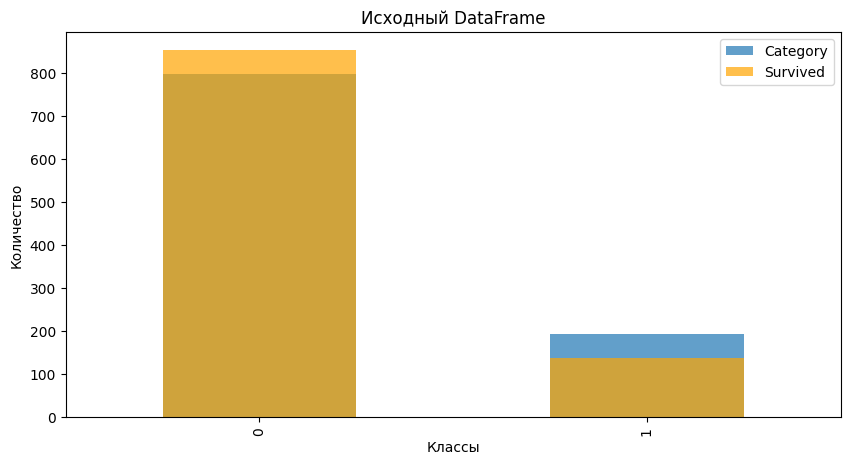

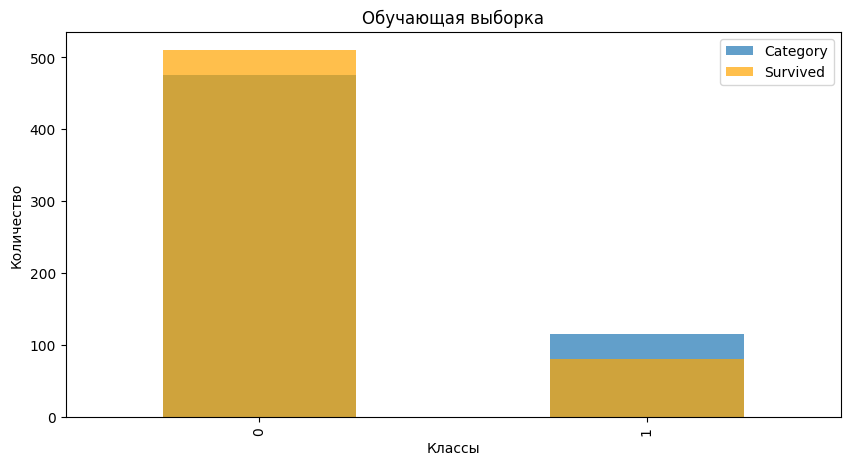

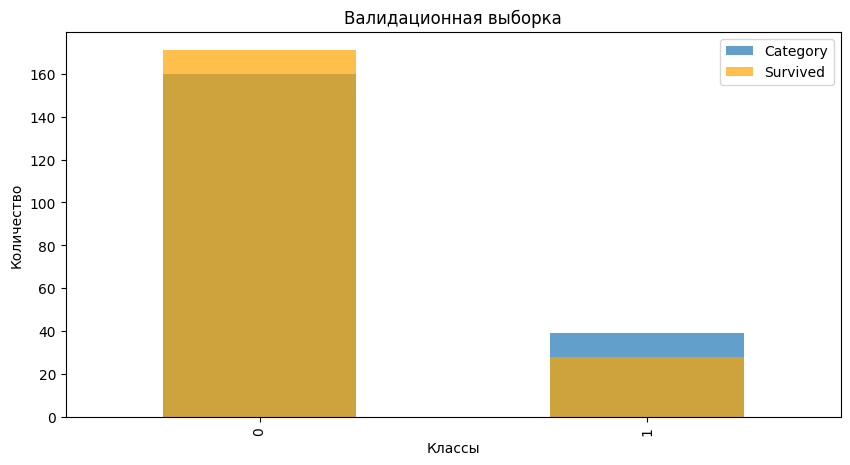

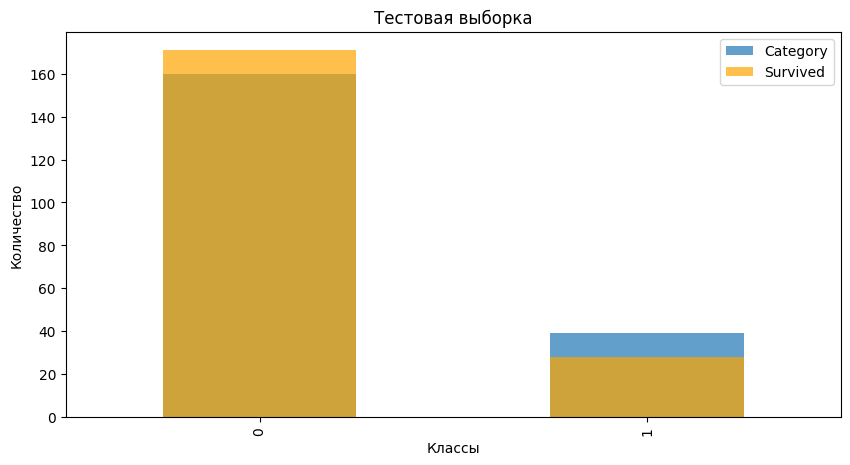

In [6]:
def check_distribution(df, title):
    print(f"Распределение в {title}:")
    print(df['Category'].value_counts(normalize=True))  
    print(df['Survived'].value_counts(normalize=True))
    print("\n")

check_distribution(df, "Исходном DataFrame")
check_distribution(train, "Обучающей выборке")
check_distribution(val, "Валидационной выборке")
check_distribution(test, "Тестовой выборке")

def plot_distribution(df, title):
    plt.figure(figsize=(10, 5))
    df['Category'].value_counts().plot(kind='bar', alpha=0.7, label='Category')
    df['Survived'].value_counts().plot(kind='bar', alpha=0.7, label='Survived', color='orange')
    plt.title(title)
    plt.xlabel('Классы')
    plt.ylabel('Количество')
    plt.legend()
    plt.show()

plot_distribution(df, "Исходный DataFrame")
plot_distribution(train, "Обучающая выборка")
plot_distribution(val, "Валидационная выборка")
plot_distribution(test, "Тестовая выборка")

# Задача 6. Линрег
Допустим, у вас есть два множества A и B точек на плоскости. Линейная регрессия на плоскости -- это просто прямая, ее можно представить как функцию  y=ax+b .

Линейная регрессия, обученная на множестве А, имеет коэффициент  a>0 . То же самое верно и для линейной регрессии, обученной на множестве B. Правда ли, что если обучить линейную регрессию на множестве  A∪B , то у полученной прямой коэффициент a будет больше 0?

Если да - докажите, если нет - постройте контрпример.

### Ответ - нет, ниже контрпример

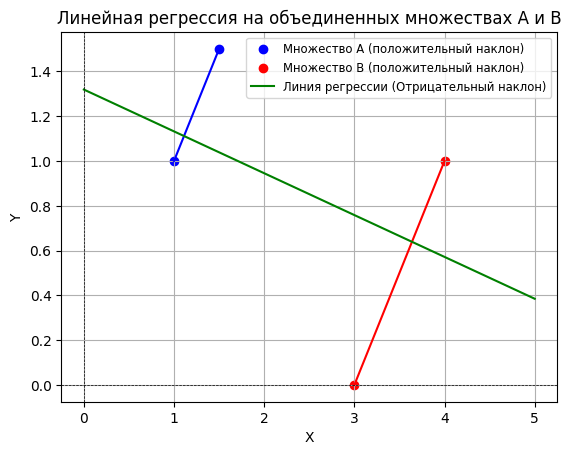

Коэффициент a для A: 1, Свободный член b: 0
Коэффициент a для B: 1, Свободный член b: 3
Коэффициент a: -0.18681318681318676, Свободный член b: 1.3186813186813184


In [7]:
from sklearn.linear_model import LinearRegression

A = np.array([[1, 1], [1.5, 1.5]])  
B = np.array([[3, 0], [4, 1]])  

X = np.concatenate((A[:, 0], B[:, 0])).reshape(-1, 1) 
y = np.concatenate((A[:, 1], B[:, 1]))

reg = LinearRegression().fit(X, y)

a = reg.coef_[0]
b = reg.intercept_


plt.scatter(A[:, 0], A[:, 1], color='blue', label='Множество A (положительный наклон)')
plt.scatter(B[:, 0], B[:, 1], color='red', label='Множество B (положительный наклон)')
plt.plot(A[:, 0], A[:, 1], color='blue')
plt.plot(B[:, 0], B[:, 1], color='red')

x_line = np.linspace(0, 5, 100).reshape(-1, 1)
y_line = reg.predict(x_line)

plt.plot(x_line, y_line, color='green', label='Линия регрессии (Отрицательный наклон)')


plt.title('Линейная регрессия на объединенных множествах A и B')
plt.xlabel('X')
plt.ylabel('Y')
plt.axhline(0, color='black',linewidth=0.5, ls='--')
plt.axvline(0, color='black',linewidth=0.5, ls='--')
plt.grid()
plt.legend(fontsize= 'small')
plt.show()

print(f"Коэффициент a для A: {1}, Свободный член b: {0}")
print(f"Коэффициент a для B: {1}, Свободный член b: {3}")
print(f"Коэффициент a: {a}, Свободный член b: {b}")